# Assignment 0 Part 1 - Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are a foundational model in deep learning, particularly for tasks involving visual data. Since their inception, CNNs have become central to computer vision, enabling advancements in areas like image classification, object detection, and segmentation. The key strength of CNNs lies in their ability to automatically learn hierarchical patterns in images, capturing features such as edges, textures, and complex structures as we progress through the layers.

The history of CNNs dates back to the 1980s with the introduction of concepts like weight sharing and local connectivity, which set CNNs apart from traditional neural networks. However, it wasn’t until the early 2010s that CNNs gained widespread recognition, largely due to the success of the AlexNet model in the 2012 ImageNet competition. This breakthrough demonstrated the efficacy of deep CNNs in handling large-scale image datasets and catalyzed a wave of research and development in the field.

In this assignment, we'll start by focusing on image classification—a classic application of CNNs. You will explore different types of convolutions, including depthwise separable convolutions, which reduce the computational cost by separating the spatial and channel-wise operations. We'll also delve into 1x1 convolutions, often used for dimensionality reduction, and bottleneck blocks, which are a combination of these techniques to make deep networks more efficient. Through these exercises, you'll gain a hands-on understanding of the various convolutional operations and how they contribute to building powerful and efficient CNN architectures.

We will be using PyTorch for this assignment and the other two parts. Hence, it is recommended you brush up on your PyTorch before starting this assignment.

Here is a list of resources to help you with this part:
- [CS231n CNNs](https://cs231n.github.io/convolutional-networks/) - A great writeup on CNNs, both for beginners and people looking for a refresher.
- [DeepLearningAI Intro to CNNs](https://youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&si=VI-V6EPFE-6DvAzE) - A free YouTube playlist to understand CNNs and other topics in Computer Vision.
- [learnpytorch.io](https://www.learnpytorch.io/) - an online and free book for learning PyTorch. Take out a few hours to go through the first few chapters till you are familiar with Image Classification.
- [PyTorch Official Intro to Image Classification](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) - If you want a faster primer, this will be helpful.
- [Intro to Separable Convolutions](https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728) - A nice primer for Task 3.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets

from tqdm import tqdm
import matplotlib.pyplot as plt

def get_num_params(model: nn.Module):
    '''Returns the number of parameters in a PyTorch model'''
    return sum(p.numel() for p in model.parameters())

## Task 0. Getting our Data

For this assignment, we'll be using the CIFAR10 dataset, a widely-used benchmark in computer vision that consists of 60,000 32x32 color images across 10 different classes. The dataset is conveniently available through the `torchvision` library, which provides a straightforward way to load and work with these images.

We begin by loading CIFAR10 using `torchvision.datasets`, where we'll download the dataset and prepare it for training and testing. To improve the robustness of our models, we'll set up a series of augmentations. These augmentations might include random horizontal flips, random crops, or normalization, all designed to simulate variations that the model might encounter in real-world scenarios. This not only helps in preventing overfitting but also enhances the model's ability to generalize.

Once the dataset and augmentations are defined, we'll utilize PyTorch’s `DataLoader` to manage the batching, shuffling, and efficient loading of the data during training. The `DataLoader` ensures that the model receives data in an optimized manner, which is crucial for speeding up the training process and maintaining model performance.

Finally, it’s always beneficial to visualize your data before diving into model training. By plotting a few batches of images along with their corresponding labels, you can get a quick sense of the dataset and confirm that the augmentations are being applied correctly. This step is crucial for catching any issues early on and ensuring that your data pipeline is functioning as expected.

You don't have to do anything for this part.

In [2]:
# Load in the CIFAR-10 dataset
root = "./data"

tfms = transforms.Compose([ # add a chain of train of transformations to each image in the dataset
    transforms.Resize((224, 224)), # resize each image from 32x32 to 224x224. large sizes help to retain more information but are computationally expensive
    transforms.ToTensor(), # convert each image to a PyTorch tensor (C x H x W) where C is the number of channels (3 for RGB), H is the height, and W is the width
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalize each tensor by subtracting 0.5 (mean) and dividing by 0.5 (st dev). This scales the pixel values from [0, 1] to [-1, 1]
])
trainset = datasets.CIFAR10(
    root, train=True, download=True, transform=tfms # 50,000 training images
)
testset = datasets.CIFAR10(
    root, train=False, download=True, transform=tfms # 10,000 test images
)

# Define DataLoaders
batch_size = 32 # number of samples in each batch. large batch sizes can speed up training but require more memory and can lead to worse generalization due to less accurate gradient estimates. small batch sizes can improve generalization but are slower to train per epoch
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True) # shuffle the training data to improve generalization
test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False) # no need to shuffle the test data

100%|██████████| 170498071/170498071 [00:03<00:00, 49325267.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


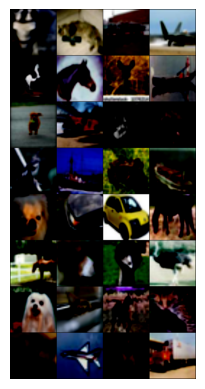

In [3]:
# Visualize a batch
grid_img = torchvision.utils.make_grid(
    tensor=next(iter(train_dl))[0], # grab a batch of images from the DataLoader
    nrow=4
)
plt.imshow(grid_img.permute(1,2,0)) # move the channel axis to the end
plt.axis(False)
plt.show()

## Task 1 - Training a plain CNN from Scratch

Now that we've set up our data pipeline, it's time to build your first Convolutional Neural Network (CNN). For this part of the assignment, you'll create a CNN architecture of your choice using basic building blocks provided by PyTorch: `nn.Conv2d`, `nn.MaxPool2d`, `nn.ReLU`, and `nn.Linear`. These components form the backbone of many classic CNN architectures, allowing you to understand the core principles without getting bogged down by complex layers or operations.

One straightforward approach is to design a network similar to AlexNet or VGG-16. These architectures are characterized by alternating layers of convolution, max pooling, and activation functions. Specifically, you'll start by applying `nn.Conv2d` to extract features from the input images. This will be followed by `nn.MaxPool2d` to downsample the feature maps, reducing their spatial dimensions and computational load while retaining important information. The `nn.ReLU` activation function is then applied to introduce non-linearity, enabling the network to learn more complex patterns.

As you stack these layers, you'll progressively increase the depth of the network, capturing increasingly abstract features. Finally, you'll flatten the feature maps and pass them through fully connected layers (`nn.Linear`) to perform classification.

At this stage, there's no need to experiment with advanced techniques or fine-tuning. The goal is to become comfortable with constructing a basic CNN and understanding how each component contributes to the model's overall performance. In the subsequent sections, we'll explore more sophisticated techniques and architectures, but for now, focus on getting this foundational CNN up and running.

In [4]:
# Create a CNN from scratch
class CNN(nn.Module):
    def __init__(self, num_classes: int = 10):

        super(CNN, self).__init__()

        # this is the feature extraction block. it consists of a series of convolutional layers that learn to extract features from the input image
        # example input: (32, 3, 224, 224) where 32 is the batch size, 3 is the number of channels (RGB), and 224x224 is the image size
        self.features = nn.Sequential( # a sequential container that holds a series of layers that are executed in order from left to right
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), # 3 input channels (RGB), 64 output channels, 11x11 kernel size, 4 stride, 2 padding. the output size is (N - F + 2P)/S + 1 = (224 - 11 + 2*2)/4 + 1 = 55 where N is the input size, F is the kernel size, P is the padding, and S is the stride. output size is (32, 64, 55, 55). the number of parameters is (3*11*11*64) + 64 = 23,296 + 64 = 23,360 where 3 is the number of input channels, 11x11 is the kernel size, 64 is the number of output channels, and 64 is the bias term for each output channel 
            nn.ReLU(inplace=True), # apply the ReLU activation function to the output of the convolutional layer to introduce non-linearity and learn complex patterns in the data. 
            nn.MaxPool2d(kernel_size=3, stride=2), # apply max pooling to the output of the ReLU layer to downsample the feature maps and reduce the spatial dimensions. this helps to make the model more robust to variations in the input data. the output size is (32, 64, 27, 27) where 27 = (55 - 3)/2 + 1. The formula for pooling layers is the same as convolutional layers but without the kernel size term since pooling layers do not have learnable parameters.
            nn.Conv2d(64, 192, kernel_size=5, padding=2), # the output size is (32, 192, 27, 27). the number of parameters is (64*5*5*192) + 192 = 307,392 + 192 = 307,584 where 64 is the number of input channels, 5x5 is the kernel size, 192 is the number of output channels, and 192 is the bias term for each output channel. the calculation of 27 is: (27 - 5 + 2*2)/1 + 1 = 27
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=3, stride=2), # the output size is (32, 192, 13, 13) where 13 = (27 - 3)/2 + 1
            nn.Conv2d(192, 384, kernel_size=3, padding=1), # the output size is (32, 384, 13, 13). the number of parameters is (192*3*3*384) + 384 = 663,936 + 384 = 664,320 where 192 is the number of input channels, 3x3 is the kernel size, 384 is the number of output channels, and 384 is the bias term for each output channel. the calculation of 13 is: (13 - 3 + 2*1)/1 + 1 = 13
            nn.ReLU(inplace=True), 
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # the output size is (32, 256, 13, 13). the number of parameters is (384*3*3*256) + 256 = 884,992 + 256 = 885,248 where 384 is the number of input channels, 3x3 is the kernel size, 256 is the number of output channels, and 256 is the bias term for each output channel. the calculation of 13 is: (13 - 3 + 2*1)/1 + 1 = 13. the number of output channels have been decreased because the number of output channels is a hyperparameter that can be tuned to control the capacity of the model. in this case, the number of output channels has been reduced to prevent overfitting and reduce the number of parameters in the model.
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # the output size is (32, 256, 13, 13). the number of parameters is (256*3*3*256) + 256 = 590,080 + 256 = 590,336 where 256 is the number of input channels, 3x3 is the kernel size, 256 is the number of output channels, and 256 is the bias term for each output channel. the calculation of 13 is: (13 - 3 + 2*1)/1 + 1 = 13. the number of output channels has been kept the same to maintain the capacity of the model and learn more complex patterns in the data.
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # the output size is (32, 256, 6, 6) where 6 = (13 - 3)/2 + 1. the spatial dimensions have been reduced to 6x6 to prepare the data for the classification block. the number of output channels has been kept the same to maintain the capacity of the model and learn more complex patterns in the data. the number of parameters is (256*6*6*256) + 256 = 1,179,904 + 256 = 1,180,160 where 256 is the number of input channels, 6x6 is the spatial dimensions, 256 is the number of output channels, and 256 is the bias term for each output channel.
        )

        self.classifier = nn.Sequential( # this is the classification block. it consists of a series of fully connected layers that learn to classify the input image into one of the output classes 
            nn.Dropout(), # apply dropout to the output of the convolutional block to prevent overfitting by randomly setting a fraction of the input units to zero during training. this helps to improve the generalization of the model and reduce the risk of memorizing the training data.
            # the last conv layer gave us 256 feature maps of size 6x6. now we map the extracted features to a higher-dimensional space for classification, generating 4096 output features (neurons) 
            nn.Linear(256 * 6 * 6, 4096), # the number of parameters is (256*6*6*4096) + 4096 = 37,748,736 + 4096 = 37,752,832 where 256 is the number of input channels, 6x6 is the spatial dimensions, 4096 is the number of output channels, and 4096 is the bias term for each output channel. the spatial dimensions have been flattened to a vector of size 256*6*6 = 9216 to prepare the data for the fully connected layers.
            nn.ReLU(inplace=True), # apply the ReLU activation function to the output of the fully connected layer to introduce non-linearity and learn complex patterns in the data.
            nn.Dropout(), # dropout is applied again because the fully connected layers have a large number of parameters and are prone to overfitting. applying dropout helps to improve the generalization of the model and reduce the risk of memorizing the training data.
            nn.Linear(4096, 4096),  # the number of parameters is (4096*4096) + 4096 = 16,781,312 + 4096 = 16,785,408 where 4096 is the number of input channels, 4096 is the number of output channels, and 4096 is the bias term for each output channel.
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes) # the number of parameters is (4096*10) + 10 = 40,960 + 10 = 40,970 where 4096 is the number of input channels, 10 is the number of output classes, and 10 is the bias term for each output class. the output size is (32, 10) where 10 is the number of output classes.
        )

        # simply, what does the number of parameters mean with respect to the CIFAR-10 dataset? 
        # the number of parameters in a model is a measure of the model's capacity to learn patterns in the data. 
        # a model with more parameters has a higher capacity to learn complex patterns in the data but is also more prone to overfitting.

    def forward(self, x): # this function handles how input tensor flows through the network layers: first extract features, then flatten the output, and finally classify the input by generating probabilities for each of the 10 classes
        x = self.features(x) # pass the input through the feature extraction block
        x = torch.flatten(x, 1)  # flatten all dimensions except batch to prepare the data for the fully connected layers
        x = self.classifier(x) # pass the input through the classification block to get the output logits. the output logits are unnormalized scores that represent the model's confidence in each class. for example if the output logits are [2.0, 1.0, 0.1], the model is most confident that the input belongs to class 0, less confident that the input belongs to class 1, and least confident that the input belongs to class 2. the output logits are then passed through a softmax function to convert them into probabilities that sum to 1.0. for example if the output logits are [2.0, 1.0, 0.1], the output probabilities are [0.7, 0.2, 0.1]. the class with the highest probability is the predicted class.
        return x

In [5]:
# Instantiate your model
model = CNN(num_classes=10)

# Do a dummy forward pass on a batch from the DataLoader
# This will help you debug shape errors
x = next(iter(train_dl))[0]
logits = model(x)
print(logits.shape)

# logits have shape (32, 10) where 32 is the batch size and 10 is the number of output classes. this means that the model has made predictions for 32 images and assigned a confidence score to each of the 10 classes for each image.

print(f"Model has {get_num_params(model)} parameters.")

torch.Size([32, 10])
Model has 57044810 parameters.


Before diving into the training process, we recommend reviewing a tutorial on image classification with PyTorch if you're not already familiar with it. This will give you a solid foundation in the key concepts and functions we'll be using.

In the cell below, you'll train your CNN using the `nn.CrossEntropyLoss` as the loss function, which is standard for multi-class classification tasks. For optimization, we'll use the `Adam` optimizer with a learning rate of `3e-4`, a good starting point for training deep networks. You'll train the model for 10 epochs, which should be sufficient to observe significant learning without overfitting or excessive training time.

If you find that your model is running slowly or consuming too much memory, consider revisiting your architecture. Simplifying the model or reducing its depth can speed up training and reduce the risk of running into issues, especially if you're working with limited resources.

The target here is to achieve around 70% validation accuracy. This might seem modest, but remember that we're training the model from scratch, and this is just the beginning. Hitting this benchmark indicates that your model is learning and generalizing reasonably well.

It's crucial to use a GPU for training, as it will dramatically speed up the process. Be cautious of device-related errors—ensure that your tensors and model are consistently placed on the GPU by using `.to(device)` where `device` is either `"cuda"` or `"cpu"` based on availability.

To streamline your code, define functions for a single training step and a single validation step. This not only makes your code cleaner but also modular, meaning you can easily swap out or modify components in future experiments. You can refer to the relevant chapter in [learnpytorch.io](https://www.learnpytorch.io) for a detailed guide on structuring these functions. Packaging everything into functions is a best practice that allows you to experiment with different models, datasets, or hyperparameters without rewriting large portions of your code.

In [6]:
# Instantiate loss function, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss()

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [7]:
# Define train_step and eval_step
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients to prevent them from accumulating and causing incorrect updates
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels) # calculate the loss between the model's predictions and the actual labels

        # Backward pass and optimization
        loss.backward() # compute the gradient of the loss with respect to the model's parameters
        optimizer.step() # update the model's parameters using the gradients

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0) # multiply the loss by the number of inputs in the batch to get the total loss
        _, preds = torch.max(outputs, 1) 
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct_predictions.double() / total_predictions

    return epoch_loss, epoch_accuracy

@torch.inference_mode
def eval_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               device: str):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = correct_predictions.double() / total_predictions

    return epoch_loss, epoch_accuracy

Now that we've defined our model, loss function, optimizer, and training setup, it's time to actually run the training process. Using the functions you've defined earlier, you'll train the model on the CIFAR10 dataset over the specified number of epochs.

As you train the model, it's important to monitor the training progress by printing out the loss and accuracy values after each epoch. This provides insight into how well the model is learning and whether adjustments might be needed. Make sure to save these values—both loss and accuracy for training and validation sets—so you can plot them later. These plots, often referred to as loss curves, will help you visualize the model's learning dynamics and diagnose any issues such as overfitting or underfitting.

If you haven't already, make sure you're using a GPU to accelerate the training. Training deep networks on a CPU can be prohibitively slow, whereas a GPU can dramatically reduce the time required for each epoch. Before starting the training loop, ensure that both your model and data are correctly placed on the GPU by using `.to(device)`.

As you run the training, keep an eye on the output for any potential issues, such as device mismatches or unusually high loss values, which could indicate problems in the data pipeline or model configuration. By the end of training, you should have a trained model with logged performance metrics, ready for evaluation and further experimentation.

In [8]:
# Train for no more than 10 epochs (be sure to save the loss and accuracy values somewhere!)
# Train for no more than 10 epochs (be sure to save the loss and accuracy values somewhere!)
num_epochs = 10
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train step
    train_loss, train_accuracy = train_step(
        model=model,
        dataloader=train_dl,  # Assuming train_dataloader is defined
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
    )

    # Evaluation step
    val_loss, val_accuracy = eval_step(
        model=model,
        dataloader=test_dl,  # Assuming val_dataloader is defined
        loss_fn=loss_fn,
        device=device
    )

    # Save the loss and accuracy values
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    # Print the results
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 1.5389 | Train Accuracy: 0.4292
Val Loss: 1.1740 | Val Accuracy: 0.5842
Epoch 2/10
Train Loss: 1.0653 | Train Accuracy: 0.6214
Val Loss: 0.9262 | Val Accuracy: 0.6729
Epoch 3/10
Train Loss: 0.8666 | Train Accuracy: 0.6945
Val Loss: 0.8222 | Val Accuracy: 0.7180
Epoch 4/10
Train Loss: 0.7427 | Train Accuracy: 0.7418
Val Loss: 0.7584 | Val Accuracy: 0.7383
Epoch 5/10
Train Loss: 0.6459 | Train Accuracy: 0.7746
Val Loss: 0.7666 | Val Accuracy: 0.7431
Epoch 6/10
Train Loss: 0.5706 | Train Accuracy: 0.7989
Val Loss: 0.6686 | Val Accuracy: 0.7778
Epoch 7/10
Train Loss: 0.5106 | Train Accuracy: 0.8221
Val Loss: 0.7001 | Val Accuracy: 0.7713
Epoch 8/10
Train Loss: 0.4521 | Train Accuracy: 0.8423
Val Loss: 0.6683 | Val Accuracy: 0.7799
Epoch 9/10
Train Loss: 0.4023 | Train Accuracy: 0.8571
Val Loss: 0.6483 | Val Accuracy: 0.7912
Epoch 10/10
Train Loss: 0.3653 | Train Accuracy: 0.8719
Val Loss: 0.6438 | Val Accuracy: 0.7930


time taken: 25m

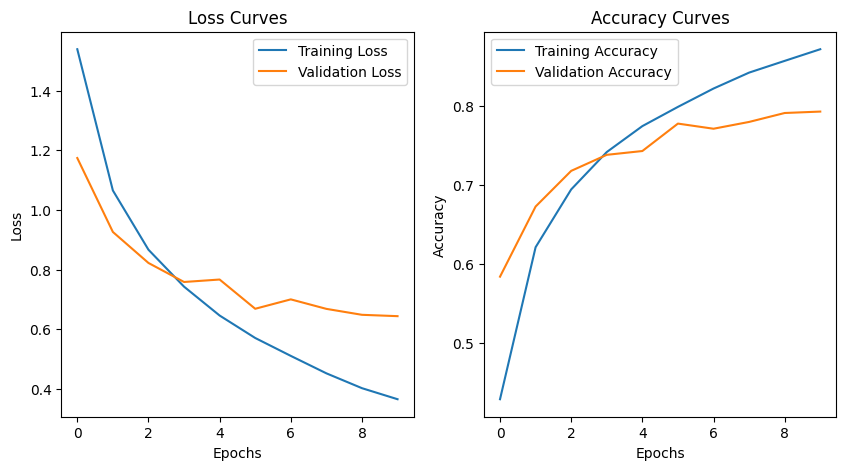

In [10]:
# Convert tensors to NumPy arrays (if they are still tensors)
train_loss_values = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_loss_values]
train_accuracy_values = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_accuracy_values]
val_loss_values = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_loss_values]
val_accuracy_values = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_accuracy_values]

# Visualize the loss curves
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(val_accuracy_values, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Task 2 - Using 1x1 Convolutions to create Bottlenecks

1x1 convolutions are a powerful tool in modern deep learning architectures, particularly when working with convolutional neural networks. Unlike traditional convolutions, which typically use larger kernels like 3x3 or 5x5, a 1x1 convolution applies a single filter across each pixel location, effectively operating on the depth dimension of the input tensor. This seemingly simple operation has been widely adopted in advanced architectures like InceptionNet and MobileNet due to its ability to reduce computational complexity while retaining valuable information.

One of the primary uses of 1x1 convolutions is to downsample the number of channels in a tensor. For instance, imagine you have a tensor with a large number of channels after applying several convolutions. A 1x1 convolution can be used to reduce the channel dimension, significantly decreasing the computational overhead before applying more complex operations like a 3x3 convolution. After the 3x3 convolution, another 1x1 convolution can be applied to upsample the channels back to their original size or to a desired dimension. This three-stage approach—downsampling, applying the 3x3 convolution, and then upsampling—forms the basis of the bottleneck block, which is a cornerstone of many efficient deep learning models.

To illustrate the efficiency of this method, let’s consider a small numerical example. Suppose you have an input tensor with 256 channels, and you want to apply a 3x3 convolution that outputs 512 channels. A direct 3x3 convolution would involve $256 \times 512 \times 3 \times 3 = 1,179,648$ parameters. However, if you first downsample the 256 channels to 64 using a 1x1 convolution, apply the 3x3 convolution on the reduced tensor, and then upsample back to 512 channels with another 1x1 convolution, the total number of parameters becomes $256 \times 64 \times 1 \times 1 + 64 \times 512 \times 3 \times 3 + 512 \times 256 \times 1 \times 1 = 16,384 + 294,912 + 131,072 = 442,368$ parameters. As you can see, this approach requires significantly fewer parameters than the direct method, even though it introduces additional layers. This not only reduces the model’s size but also makes it more efficient to train.

Your next task will be to implement this type of architecture using bottleneck blocks, which were popularized by the ResNet architecture. ResNet, introduced in the paper ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385), leverages bottleneck blocks to allow the construction of very deep networks while maintaining computational efficiency. The residual connections in ResNet help in mitigating the vanishing gradient problem, making it feasible to train networks with hundreds or even thousands of layers.

By implementing bottleneck blocks in your model, you’ll explore how deeper architectures can be both powerful and efficient, leveraging the combination of 1x1 convolutions and residual connections to push the boundaries of what CNNs can achieve.

In [11]:
# 1x1 convs are different from 3z3 and 5x5 filters, the latter are used to capture spatial information while the former is used to capture channel-wise information.
# a 1x1 convolution applies a filter to each pixel independently across the depth dimension (channels)
# traditional convolutions (e.g., 3x3 or 5x5), which operate on a spatial neighborhood of pixels (3x3 matrix of pixels )

# the idea is to reduce the number of channels in the feature maps to reduce the computational cost of the model.
# this dimensionality reduction significantly reduces the number of parameters in the network, making it more efficient to train 

# Bottleneck block has 3 stages:
# 1. Downsampling 1x1 Convolution: reduces the number of channels in the input feature map to reduce the computational cost of the model
# 2. 3x3 Convolution: captures spatial information in the input feature map
# 3. Upsampling 1x1 Convolution: increases the number of channels in the output feature map to restore the lost information

# Instantiate a tensor for demonstration
in_channels = 64
h, w = 224, 224
bs = 8
out_channels = 256

x = torch.randn(bs, in_channels, h, w) # random tensor simulating a batch of 8 images with 64 input channels and spatial dimensions of 224x224

In [12]:
# A regular 3x3 Conv
layer = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False) # number of parameters is (64*3*3*256) = 147,456 where 64 is the number of input channels, 3x3 is the kernel size, and 256 is the number of output channels. the bias term is set to False to exclude the bias term from the calculation of the number of parameters
layer(x).shape

torch.Size([8, 256, 224, 224])

In [13]:
# The bottleneck using 1x1 Convs - note the same shape as above
bottleneck_channels = in_channels // 4 # divide the number of input channels by 4 to reduce the number of parameters in the bottleneck layer. bottleneck_channels = 64//4 = 16

# bottleneck 1x1 conv layer
layer = nn.Sequential(
    
    # downsample using a 1x1 Conv layer to reduce the number of input channels
    nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0, bias=False), # number of parameters is (64*1*1*16) = 1,024 where 64 is the number of input channels, 1x1 is the kernel size, and 16 is the number of output channels. the bias term is set to False to exclude the bias term from the calculation of the number of parameters because the bias term is not necessary in the bottleneck layer
    
    # apply 3z3 Conv layer to learn complex spatial patterns in the data, operating on a reduced dimensional space 
    nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1, bias=False), # number of parameters is (16*3*3*16) = 2,304 where 16 is the number of input channels, 3x3 is the kernel size, and 16 is the number of output channels. 
    
    # upsample using a 1x1 Conv layer to increase the number of output channels back to the original value
    nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False) # number of parameters is (16*1*1*256) = 4,096 where 16 is the number of input channels, 1x1 is the kernel size, and 256 is the number of output channels.
)

layer(x).shape # the output shape is the same as the regular 3x3 Conv layer because the bottleneck layer has the same number of output channels as the regular 3x3 Conv layer. the number of parameters in the bottleneck layer is less than the regular 3x3 Conv layer because the number of input channels is reduced by a factor of 4.

torch.Size([8, 256, 224, 224])

In [14]:
# Some helper functions to help you tinker with comparing a single 3x3 conv against the three-stage approach
def get_standard_conv(in_channels: int,
                        out_channels: int):

    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

def get_bottleneck_conv(in_channels: int,
                        out_channels: int,
                        bottleneck_channels: int):

    return nn.Sequential(
        nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0),
        nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1),
        nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, padding=0)
    )

# Demonstrating how they have the same effect
x = torch.randn(8, 64, 224, 224)
out_1 = get_standard_conv(64, 32)(x)
out_2 = get_bottleneck_conv(64, 32, bottleneck_channels=16)(x) # downsample by a factor of 4
print(out_1.shape)
print(out_2.shape)

torch.Size([8, 32, 224, 224])
torch.Size([8, 32, 224, 224])


In this section, you'll explore the practical benefits of using bottleneck blocks by comparing them with a more straightforward CNN architecture. A simple implementation of a CNN, `PlainCNN`, using regular 3x3 convolutions, has been provided. Your task is to complete the forward pass of this model without modifying the constructor. This ensures that the architecture is consistent, allowing for a fair comparison.

Next, you'll implement a `BottleneckCNN` model that mirrors the architecture of `PlainCNN`, but with a key difference: the standard convolutional blocks will be replaced by bottleneck blocks. These bottleneck blocks use 1x1 convolutions to downsample and upsample the channel dimensions, reducing the overall number of parameters while maintaining—or even improving—the network's capacity to learn complex features.

Once both models are implemented, instantiate them and compare the number of parameters. You’ll likely find that the `BottleneckCNN` has significantly fewer parameters than `PlainCNN`, despite achieving a similar or better feature extraction capability. This reduction in parameters demonstrates how bottleneck blocks, with their use of 1x1 convolutions, can lead to more efficient models without sacrificing performance.

This comparison not only reinforces the concept of efficient model design but also highlights the practical utility of architectural innovations like the bottleneck block, as popularized by the ResNet architecture. By experimenting with these models, you’ll gain a deeper understanding of how design choices impact both the size and efficiency of deep learning networks.

In [15]:
class PlainCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            # Initial Conv layer with kernel size of 7
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Using get_standard_conv to build subsequent layers
            get_standard_conv(64, 128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(128, 256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_standard_conv(256, 512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layer
        self.head = nn.Linear(512 * 7 * 7, num_classes)  # Assuming input image size of 224x224

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.head(x)
        return x

# Initialize model and do a dummy forward pass
plain_cnn = PlainCNN(10)
plain_cnn(next(iter(train_dl))[0]).shape

torch.Size([32, 10])

In [17]:
class BottleneckCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        self.features = nn.Sequential(
            # Initial Conv layer with kernel size of 7
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Using get_standard_conv to build subsequent layers
            get_bottleneck_conv(64, 128, 64 // 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_bottleneck_conv(128, 256, 128 // 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            get_bottleneck_conv(256, 512, 256 // 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layer
        self.head = nn.Linear(512 * 7 * 7, num_classes)  # Assuming input image size of 224x224

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.head(x)
        return x

# Initialize model and do a dummy forward pass
bottleneck_cnn = BottleneckCNN(10)
bottleneck_cnn(next(iter(train_dl))[0]).shape

torch.Size([32, 10])

In [18]:
# Compare the number of parameters across both
print(f"PlainCNN has {get_num_params(plain_cnn)} parameters.")
print(f"BottleneckCNN has {get_num_params(bottleneck_cnn)} parameters.")

PlainCNN has 1809546 parameters.
BottleneckCNN has 374378 parameters.


In [23]:
bottleneck_cnn = BottleneckCNN(10).to(device)

# Train the BottleneckCNN in the same fashion as before
# Train for no more than 10 epochs (be sure to save the loss and accuracy values somewhere!)
num_epochs = 10
train_loss_values_bottleneck = []
train_accuracy_values_bottleneck = []
val_loss_values_bottleneck = []
val_accuracy_values_bottleneck = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train step
    train_loss, train_accuracy = train_step(
        model=bottleneck_cnn,
        dataloader=train_dl,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(bottleneck_cnn.parameters()),
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Evaluation step
    val_loss, val_accuracy = eval_step(
        model=bottleneck_cnn,
        dataloader=test_dl,
        loss_fn=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Save the loss and accuracy values, ensuring they're moved to the CPU and converted to NumPy
    train_loss_values_bottleneck.append(train_loss)
    train_accuracy_values_bottleneck.append(train_accuracy)
    val_loss_values_bottleneck.append(val_loss)
    val_accuracy_values_bottleneck.append(val_accuracy)

    # Print the results
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 1.5536 | Train Accuracy: 0.4398
Val Loss: 1.1382 | Val Accuracy: 0.5909
Epoch 2/10
Train Loss: 0.9664 | Train Accuracy: 0.6633
Val Loss: 0.9068 | Val Accuracy: 0.6865
Epoch 3/10
Train Loss: 0.7836 | Train Accuracy: 0.7311
Val Loss: 0.8272 | Val Accuracy: 0.7190
Epoch 4/10
Train Loss: 0.6711 | Train Accuracy: 0.7702
Val Loss: 0.8102 | Val Accuracy: 0.7272
Epoch 5/10
Train Loss: 0.5876 | Train Accuracy: 0.7976
Val Loss: 0.7836 | Val Accuracy: 0.7356
Epoch 6/10
Train Loss: 0.5112 | Train Accuracy: 0.8239
Val Loss: 0.7895 | Val Accuracy: 0.7431
Epoch 7/10
Train Loss: 0.4506 | Train Accuracy: 0.8428
Val Loss: 0.8420 | Val Accuracy: 0.7536
Epoch 8/10
Train Loss: 0.3982 | Train Accuracy: 0.8597
Val Loss: 0.9485 | Val Accuracy: 0.7196
Epoch 9/10
Train Loss: 0.3490 | Train Accuracy: 0.8785
Val Loss: 0.8837 | Val Accuracy: 0.7365
Epoch 10/10
Train Loss: 0.3113 | Train Accuracy: 0.8893
Val Loss: 0.9484 | Val Accuracy: 0.7439


time taken: 23m

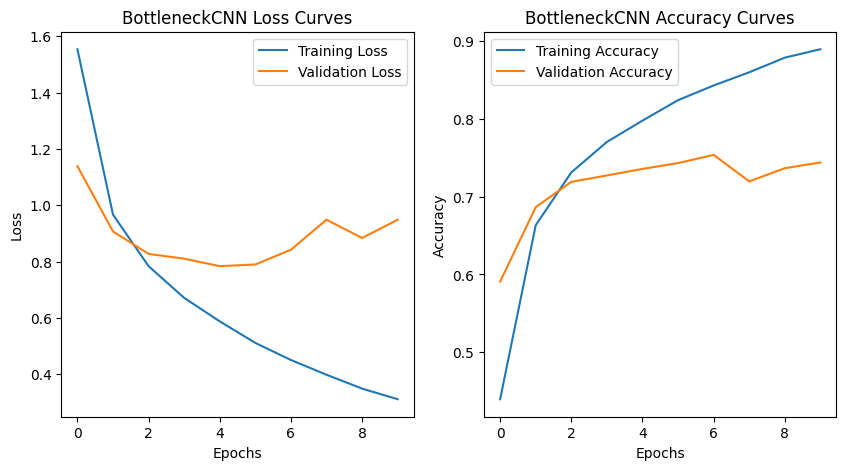

In [25]:
train_loss_values_bottleneck = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_loss_values_bottleneck]
train_accuracy_values_bottleneck = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_accuracy_values_bottleneck]
val_loss_values_bottleneck = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_loss_values_bottleneck]
val_accuracy_values_bottleneck = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_accuracy_values_bottleneck]

# Visualize the loss curves
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values_bottleneck, label='Training Loss')
plt.plot(val_loss_values_bottleneck, label='Validation Loss')
plt.title('BottleneckCNN Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values_bottleneck, label='Training Accuracy')
plt.plot(val_accuracy_values_bottleneck, label='Validation Accuracy')
plt.title('BottleneckCNN Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Task 3 - Depthwise Separable Convolutions

Depthwise Separable Convolutions are an advanced convolutional technique designed to improve the efficiency of convolutional neural networks by significantly reducing the number of parameters and computational cost. This approach decomposes the standard convolution operation into two distinct steps: depthwise convolution and pointwise convolution. By breaking down the convolution process, Depthwise Separable Convolutions offer a more efficient way to process visual data, making them a cornerstone in lightweight architectures like MobileNet.

Depthwise Separable Convolutions have been integral to the development of efficient deep learning models, particularly in mobile and resource-constrained environments. MobileNet, a well-known architecture designed for mobile and embedded vision applications, relies heavily on Depthwise Separable Convolutions to achieve high accuracy with minimal computational resources. By incorporating these convolutions, MobileNet can run on devices with limited processing power, such as smartphones, while still delivering impressive performance on tasks like image classification and object detection.

To understand Depthwise Separable Convolutions, it’s important to first grasp how they decompose a standard convolution. In a typical convolutional layer, a 3D kernel is applied across all channels of an input tensor simultaneously, mixing both the spatial and channel dimensions in a single operation. Depthwise Separable Convolutions separate this process into two distinct steps:

1. **Depthwise Convolution**: In this step, each input channel is convolved independently using a separate 2D filter. This means that if the input tensor has `C` channels, `C` different filters are applied—one per channel. The result is that each channel is processed individually, preserving the spatial structure but not mixing information between channels. This operation reduces the computational cost because it avoids the full 3D convolution process, focusing only on the spatial dimension of each channel.

2. **Pointwise Convolution**: After the depthwise convolution, a 1x1 convolution (referred to as pointwise) is applied across all the channels of the resulting tensor. This operation mixes the information across different channels, effectively combining the output of the depthwise convolution into a more meaningful representation. By only using 1x1 convolutions, pointwise convolution operates on the channel dimension, drastically reducing the number of parameters compared to a standard 3x3 or 5x5 convolution.

**Depthwise Convolution**

Depthwise convolution is the first stage of a Depthwise Separable Convolution. It involves applying a single convolutional filter to each input channel separately. For example, if the input tensor has dimensions `(H, W, C)`, where `H` is the height, `W` is the width, and `C` is the number of channels, the depthwise convolution would apply `C` separate filters to each channel, producing an output tensor of the same dimensions `(H, W, C)`.

This operation primarily focuses on capturing spatial features within each channel but does not mix information between different channels. Because it avoids cross-channel operations, the depthwise convolution is computationally efficient, significantly reducing the number of multiplication operations required.

**Pointwise Convolution**

After the depthwise convolution has processed each channel independently, pointwise convolution comes into play. This is simply a 1x1 convolution applied across the output channels of the depthwise convolution. Despite its simplicity, the pointwise convolution is crucial because it enables the network to combine information across different channels, effectively reintroducing the depth that was initially separated.

In a pointwise convolution, every output pixel is a weighted sum of the corresponding input pixels across all channels, allowing the model to learn complex combinations of features extracted by the depthwise convolution. This step significantly increases the representational power of the model while maintaining a low computational overhead compared to traditional convolutions.

**Implementing Depthwise Separable Convolutions in a Model**

Your next task is to implement a model that utilizes Depthwise Separable Convolutions. By replacing standard convolutions with depthwise and pointwise convolutions, you'll observe how this technique can lead to a more parameter-efficient model without compromising on accuracy. This exercise will deepen your understanding of how modern CNN architectures are optimized for performance, particularly in scenarios where computational resources are limited.

In [27]:
# regular convolutions use filters that mix both spatial and channel dimensions which causes a very high number of parameters
# depthwise separable convolutions have two parts: first Depthwise Convolution and then Pointwise Convolution
# Depthwise Convolution: applies a separate convolutional filter for each input channel to capture channel-wise information (spatial features for each channel independently0. output tensor has the same spatial dimensions as the input but processed independently per channel
# Pointwise conv: mix information across channels. 1x1 filter applied to combine the outputs of the depthwise conv. 1x1 conv reduce num of params compared to using 3x3 or 5x5

'''
Number of parameters calculation:

DWC: (K_H * K_W * 1) * C_in 
PWC (1x1 convolution): (1 * 1 * C_in) * C_out	
'''

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()

        # Depthwise convolution
        # Initial shape of the input tensor: (N, C_in, H_in, W_in) = (32, 32, 224, 224) where N is the batch size, C_in is the number of input channels, H_in is the height of the input image, and W_in is the width of the input image.
        # initial number of parameters: (C_in * kernel_size^2) = (32 * 3^2) = 288 where C_in is the number of input channels and kernel_size is the size of the kernel. the bias term is set to False to exclude the bias term from the calculation of the number of parameters.
        self.depthwise = nn.Conv2d(
            in_channels, # number of input channels
            in_channels, # number of output channels (same as input channels)
            kernel_size=kernel_size, # kernel size of the convolutional filter
            padding=padding, # padding to apply to the input tensor
            groups=in_channels,  # Apply a separate filter for each input channel to capture channel-wise information
            bias=False 
        )

        # Pointwise convolution
        # Initial shape of the input tensor: (N, C_in, H_in, W_in) = (32, 32, 224, 224)
        # initial number of parameters: (C_in * C_out * 1^2) = (32 * 64 * 1^2) = 2,048 where C_in is the number of input channels, C_out is the number of output channels, and 1x1 is the kernel size. the bias term is set to False to exclude the bias term from the calculation of the number of parameters.
        self.pointwise = nn.Conv2d(
            in_channels, # number of input channels = 32
            out_channels, # number of output channels = 64
            kernel_size=1, # kernel size of the convolutional filter = 1
            padding=0, # padding to apply to the input tensor = 0
            bias=False
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DepthwiseSeparableCNN(nn.Module):
    def __init__(self, num_classes: int):

        super(DepthwiseSeparableCNN, self).__init__()

        self.features = nn.Sequential(

            # Input tensor shape: [32, 3, 224, 224]

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1), # output HW: (224 - 3 + 2 * 1) / 2 + 1 = 112. => Output Shape: [32, 32, 112, 112]. Number of parameters: (3×3×3+1)×32=(27+1)×32=28×32=896
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),# Output Height = (112 - 3 + 2 * 1) / 2 + 1 = 56. => Output Shape: [32, 32, 56, 56]

            DepthwiseSeparableConv(32, 64), # DW Conv: Output HW = (56 - 3 + 2 * 1) / 1 + 1 = 56. Intermediate Shape: [32, 32, 56, 56]. PW conv (expand to 64 out channels): [32, 64, 56, 56]. Number of parameters = DWC + PWC =  (3×3×1)×32=9×32 + (1×1×32)×64=32×64 = 2048 + 288 = 2336
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output HW = (56 - 2) / 2 + 1 = 28. Output Shape: [32, 64, 28, 28]

            DepthwiseSeparableConv(64, 128), # DW Conv: Output HW = (28 - 3 + 2 * 1) / 1 + 1 = 28, Intermediate Shape: [32, 64, 28, 28]. PW conv (expand to 64 out channels): [32, 64, 56, 56]. Number of parameters = DWC + PWC = (3×3×1)×64=9×64 + (1×1×64)×128=64×128 = 8192 + 576 = 8768
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # output HW = (28 - 2) / 2 + 1 = 14. Output Shape: [32, 128, 14, 14]

            DepthwiseSeparableConv(128, 256), # DW Conv: Output HW = (14 - 3 + 2 * 1) / 1 + 1 = 14. Intermediate Shape: [32, 128, 14, 14]. PW conv (expand to 256 out channels):  [32, 256, 14, 14]. Number of parameters = DWC + PWC = (3×3×1)×128=9×128 + (1×1×128)×256=128×256 = 1152 + 32768 = 33920
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # output HW = (14 - 2) / 2 + 1 = 7. Output Shape: [32, 256, 7, 7]
        )

        # Fully connected layer
        self.head = nn.Linear(256 * 7 * 7, num_classes)  # Assuming input image size of 224x224. Fully connected layer that maps the 12544 input features to the number of classes (10). Output Shape: [32, 10]. Number of parameters: input features * output features (num of classes) + bias = (256×7×7) * (10) + 10 = 12544 * 10 + 10 = 125440 + 10 = 125450

        # total number of parameters = 896+2336+8768+33920+125450 = 171370

    def forward(self, x):
        x = self.features(x) # Output Shape: [32, 256, 7, 7]
        x = x.view(x.size(0), -1)  # Flatten the output: [32, 256 * 7 * 7] = [32, 12544]
        x = self.head(x) # Output Shape: [32, 10]
        return x

# Initialize model and do a dummy forward pass
depthwise_sep_cnn = DepthwiseSeparableCNN(10)
depthwise_sep_cnn(next(iter(train_dl))[0]).shape

torch.Size([32, 10])

In [28]:
print(f"DepthwiseSeparableCNN has {get_num_params(depthwise_sep_cnn)} parameters.")

DepthwiseSeparableCNN has 171370 parameters.


In [29]:
# Train the DepthwiseSeparableCNN in the same fashion as before
# Initialize model and move it to the device
depthwise_sep_cnn = DepthwiseSeparableCNN(10).to(device)

# Train the DepthwiseSeparableCNN
num_epochs = 10
train_loss_values_depthwise = []
train_accuracy_values_depthwise = []
val_loss_values_depthwise = []
val_accuracy_values_depthwise = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train step
    train_loss, train_accuracy = train_step(
        model=depthwise_sep_cnn,
        dataloader=train_dl,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(depthwise_sep_cnn.parameters()),
        device=device
    )

    # Evaluation step
    val_loss, val_accuracy = eval_step(
        model=depthwise_sep_cnn,
        dataloader=test_dl,
        loss_fn=nn.CrossEntropyLoss(),
        device=device
    )

    # Save the loss and accuracy values
    train_loss_values_depthwise.append(train_loss)
    train_accuracy_values_depthwise.append(train_accuracy)
    val_loss_values_depthwise.append(val_loss)
    val_accuracy_values_depthwise.append(val_accuracy)

    # Print the results
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 1.3044 | Train Accuracy: 0.5363
Val Loss: 1.0175 | Val Accuracy: 0.6432
Epoch 2/10
Train Loss: 0.8820 | Train Accuracy: 0.6954
Val Loss: 0.8652 | Val Accuracy: 0.7022
Epoch 3/10
Train Loss: 0.7095 | Train Accuracy: 0.7548
Val Loss: 0.8266 | Val Accuracy: 0.7160
Epoch 4/10
Train Loss: 0.5746 | Train Accuracy: 0.8033
Val Loss: 0.8095 | Val Accuracy: 0.7348
Epoch 5/10
Train Loss: 0.4607 | Train Accuracy: 0.8418
Val Loss: 0.8569 | Val Accuracy: 0.7301
Epoch 6/10
Train Loss: 0.3621 | Train Accuracy: 0.8739
Val Loss: 0.9097 | Val Accuracy: 0.7370
Epoch 7/10
Train Loss: 0.2897 | Train Accuracy: 0.8975
Val Loss: 1.0880 | Val Accuracy: 0.7249
Epoch 8/10
Train Loss: 0.2353 | Train Accuracy: 0.9158
Val Loss: 1.1656 | Val Accuracy: 0.7178
Epoch 9/10
Train Loss: 0.2000 | Train Accuracy: 0.9286
Val Loss: 1.3222 | Val Accuracy: 0.7128
Epoch 10/10
Train Loss: 0.1720 | Train Accuracy: 0.9382
Val Loss: 1.3279 | Val Accuracy: 0.7214


time taken: 19m

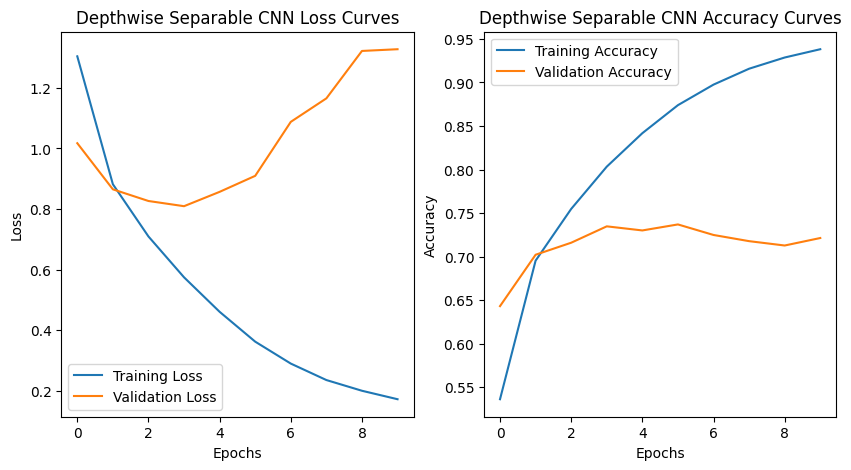

In [30]:
# Convert lists to NumPy arrays if they are tensors
train_loss_values_depthwise = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_loss_values_depthwise]
train_accuracy_values_depthwise = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in train_accuracy_values_depthwise]
val_loss_values_depthwise = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_loss_values_depthwise]
val_accuracy_values_depthwise = [t.cpu().detach().numpy() if torch.is_tensor(t) else t for t in val_accuracy_values_depthwise]

# Visualize the loss curves
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_values_depthwise, label='Training Loss')
plt.plot(val_loss_values_depthwise, label='Validation Loss')
plt.title('Depthwise Separable CNN Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_values_depthwise, label='Training Accuracy')
plt.plot(val_accuracy_values_depthwise, label='Validation Accuracy')
plt.title('Depthwise Separable CNN Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Fin.